In [120]:
import cv2
from PIL import Image, ImageOps
import os
import numpy as np
import pandas as pd
import pickle
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
import subprocess
import math

# Clone the GitHub repository to a local directory
repo_url = "https://github.com/pongsapaks/Thai-handwrittingnumberproject.git"
repo_dir = "Thai-handwrittingnumberproject"
subprocess.run(["git", "clone", repo_url, repo_dir])

image_dir = os.path.join(repo_dir, "raw")
desired_width = 28
desired_height = 28

# Fetch all image files within the directory and its subfolders
image_files = []
for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.endswith((".jpg", ".jpeg", ".png")):
            image_files.append(os.path.join(root, file))

# Initialize lists to store the image data and labels
X = []
Y = []

def make_dataset():
    global X, Y  # Declare X and Y as global variables
    
    for image_path in image_files:
        img = cv2.imread(image_path)
        
        # Skip empty or invalid images
        if img is None:
            #print(f"Failed to read image: {image_path}")
            continue
        
        img = cv2.resize(img, (desired_width, desired_height))
        if img.ndim == 2:  # Grayscale image
            img = Image.fromarray(img)
        elif img.ndim == 3:  # Color image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img)
        else:
            print(f"Invalid image format: {image_path}")
            continue
        
        img = ImageOps.invert(img)
        category = os.path.basename(os.path.dirname(image_path))
        X.append(np.array(img) / 255.0)  # Convert to numpy array and normalize
        Y.append(category)

    # Convert the lists to numpy arrays for further processing
    X = np.array(X)  # X = image
    Y = np.array(Y)  # Y = labels
    data = {"X": X, "Y": Y}
    pickle.dump(data, open("thainumber_{}.pkl".format(desired_width), "wb"), protocol=2)

def load_dataset(size=28):
    data = pickle.load(open("thainumber_{}.pkl".format(size), "rb"))
    X = data['X']
    Y = data['Y']
    return X, Y

def prepare_input(file):
    img = load_img(file, grayscale=True, target_size=(28, 28))
    img = ImageOps.invert(img)
    x = img_to_array(img)
    return x

def img_cloud_dataset(size=28):
    X, Y = load_dataset(size)
    x = 0
    y = 0
    new_im = Image.new('L', (size * 50, size * math.ceil(X.shape[0] / 50)))
    for i in range(0, X.shape[0]):
        if (i != 0 and i % 50 == 0):
            y += size
            x = 0

        img = np.expand_dims(X[i], axis=-1)  # Add channel dimension
        if img.ndim == 2:  # Grayscale image
            img = np.concatenate([img] * 3, axis=-1)  # Convert to 3 channels
        elif img.ndim == 3 and img.shape[2] == 1:  # Grayscale image with channel dimension
            img = np.concatenate([img] * 3, axis=-1)  # Convert to 3 channels
        elif img.ndim == 3 and img.shape[2] == 3:  # Color image with 3 channels
            pass  # No conversion needed
        else:
            #print(f"Invalid image format: {image_path}")
            continue

        im = array_to_img(img)
        new_im.paste(im, (x, y))
        x += size
    return new_im

# Save the image cloud dataset
new_im = img_cloud_dataset(desired_width)
new_im.save("cloud_dataset_{}.png".format(desired_width))

In [122]:
X, Y = load_dataset(desired_width)

In [123]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


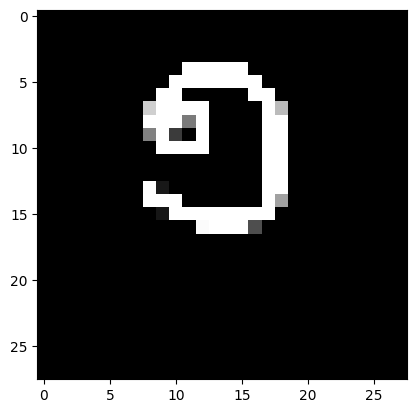

In [114]:
import matplotlib.pyplot as plt
plt.imshow(X[1], cmap='gray', vmin=0, vmax=255)

In [101]:
Y

array(['1', '1', '1', ..., '9', '9', '9'], dtype='<U2')

In [27]:
df = pd.DataFrame(dataset)
df.head

<bound method NDFrame.head of    0     1     2     3     4     5     6     7     8     9     ...  \
0  None  None  None  None  None  None  None  None  None  None  ...   
1   raw   raw   raw   raw   raw   raw   raw   raw   raw   raw  ...   

                                                1795  \
0  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
1                                                  9   

                                                1796  \
0  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
1                                                  9   

                                                1797  \
0  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
1                                                  9   

                                                1798  \
0  [[[255, 255, 255], [255, 255, 255], [255, 255,...   
1                                                  9   

                                                1799  \
0  [[[255, 255, 255], [255,